In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import torch
import torch.nn as nn

# College Admissins Dataset

Load and show raw, unprocessed data

In [3]:
dataset_file = '../Datasets/college-admissions/college_admissions.csv'
df = pd.read_csv(dataset_file)
df.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


Preprocess dataset

In [4]:
# Create dummies
temp = pd.get_dummies(df['rank'], prefix='rank')
data = pd.concat([df, temp], axis=1)
data.drop(columns='rank', inplace=True)

# Normalize
for col in ['gre', 'gpa']:
    mean, std = data[col].mean(), data[col].std()
    # data.loc[:, col] = (data[col]-mean) / std
    data[col] = (data[col]-mean) / std

# Split off random 20% of the data for testing
np.random.seed(0)  # for reproducibility
sample = np.random.choice(data.index, size=int(len(data)*0.9), replace=False)
data, test_data = data.iloc[sample], data.drop(sample)

# Split into features and targets
features_train = data.drop('admit', axis=1)
targets_train =  data['admit']
features_test = test_data.drop('admit', axis=1)
targets_test = test_data['admit']

# Convert to numpy
x_train = features_train.values            # features train set (numpy)
y_train = targets_train.values[:,None]     # targets train set (numpy)
x_test = features_test.values              # features validation set (numpy)
y_test = targets_test.values[:,None]       # targets validation set (numpy)

# Assert shapes came right way around
assert x_train.shape == (360, 6)
assert y_train.shape == (360, 1)
assert x_test.shape == (40, 6)
assert y_test.shape == (40, 1)

Train data looks like this

In [5]:
x_train[0:6].round(2)

array([[-0.07,  0.03,  0.  ,  1.  ,  0.  ,  0.  ],
       [-1.28, -1.08,  0.  ,  0.  ,  1.  ,  0.  ],
       [-0.24, -1.94,  0.  ,  0.  ,  1.  ,  0.  ],
       [ 0.63, -0.84,  0.  ,  0.  ,  1.  ,  0.  ],
       [ 0.8 , -0.13,  0.  ,  1.  ,  0.  ,  0.  ],
       [ 0.28, -0.55,  0.  ,  1.  ,  0.  ,  0.  ]])

In [6]:
y_train[0:6]

array([[0],
       [0],
       [1],
       [0],
       [0],
       [1]])

# PyTorch Model

Helper function, returns tensor

In [7]:
def accuracy(pred, tar): 
    return (pred == tar).float().mean()  # tensor!!

Model with one hidden, one output layer

In [8]:
model = nn.Sequential(
    nn.Linear(in_features=6, out_features=128),
    nn.Sigmoid(),
    nn.Linear(in_features=128, out_features=1),
    nn.Sigmoid())
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())
print(model)

Sequential(
  (0): Linear(in_features=6, out_features=128, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=128, out_features=1, bias=True)
  (3): Sigmoid()
)


Convert dataset to tensors

In [9]:
x = torch.tensor(x_train, dtype=torch.float32)
y = torch.tensor(y_train, dtype=torch.float32)

Train model

In [10]:
hist = { 'loss':[], 'acc':[] }

for epoch in range(500):  # loop over the dataset multiple times

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(x)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    predicted = outputs.data.round()
    hist['loss'].append( loss.item() )
    hist['acc'].append( accuracy(predicted, y).item() )

Show final results

In [11]:
with torch.no_grad():
    outputs = model(x)
    predicted = outputs.data.round()
    acc = accuracy(predicted, y).item() 
print(f'Accuracy on train set: {acc:.2f}')

Accuracy on train set: 0.70


In [12]:
x = torch.tensor(x_test, dtype=torch.float32)
y = torch.tensor(y_test, dtype=torch.float32)

with torch.no_grad():
    outputs = model(x)
    predicted = outputs.data.round()
    acc = accuracy(predicted, y).item() 
print(f'Accuracy on test set: {acc:.2f}')

Accuracy on test set: 0.75


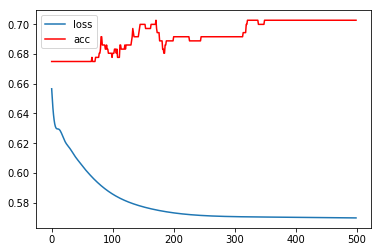

In [13]:
plt.plot(hist['loss'], label='loss')
plt.plot(hist['acc'], label='acc', color='red')
plt.legend();